In [1]:
%

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm

from patsy import dmatrix

In [17]:
df = pd.read_csv('../data/provo_natural.csv')
df['log_q'] = np.log(df['q'])
df['log_s'] = np.log(df['stage'])

In [60]:
s_range = np.linspace(df['log_s'].min(), df['log_s'].max(), 100)

<AxesSubplot:xlabel='log_s', ylabel='log_q'>

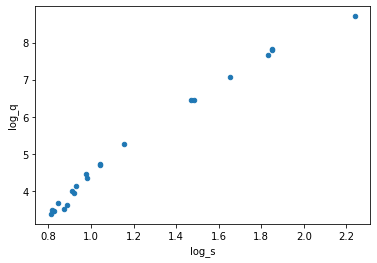

In [61]:
df.plot.scatter("log_s","log_q")

In [62]:
num_knots = 5
#knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list = np.linspace(df['log_s'].min(),df['log_s'].max(), num_knots)

In [63]:
B = dmatrix(
    "bs(log_s, knots=knots, degree=3, include_intercept=True) - 1",
    {"log_s": s_range, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (100, 7)
  Columns:
    ['bs(log_s, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(log_s, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(log_s, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(log_s, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(log_s, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(log_s, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(log_s, knots=knots, degree=3, include_intercept=True)[6]']
  Terms:
    'bs(log_s, knots=knots, degree=3, include_intercept=True)' (columns 0:7)
  (to view full data, use np.asarray(this_obj))

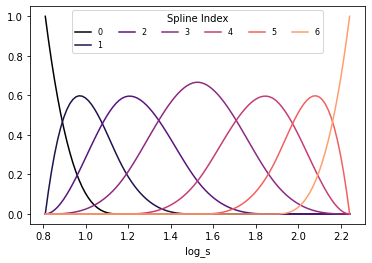

In [64]:
# plot spline
spline_df = (
    pd.DataFrame(B)
    .assign(log_s=s_range)
    .melt("log_s", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("log_s", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

<AxesSubplot:xlabel='log_s'>

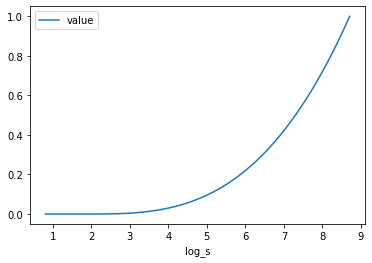

In [56]:
subset

,log_s,spline_i,value
600,1.470176,6,0.000000
601,1.040277,6,0.000000
602,1.043804,6,0.000000
603,0.815365,6,0.000000
604,0.845868,6,0.000000
...,...,...,...
695,NaN,6,0.866193
696,NaN,6,0.898449
697,NaN,6,0.931495
698,NaN,6,0.965343


In [50]:
df['log_s']

0     1.470176
1     1.040277
2     1.043804
3     0.815365
4     0.845868
5     0.819780
6     0.810930
7     0.824175
8     0.982078
9     1.156881
10    1.483875
11    1.654411
12    0.928219
13    0.920283
14    0.887891
15    0.871293
16    0.912283
17    0.978326
18    1.830980
19    1.848455
20    1.850028
21    2.240710
Name: log_s, dtype: float64